<a href="https://colab.research.google.com/github/tesla-24/PRML_residue1/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [ ]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here

# Function for normalization
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

# Sigmiod function
def usigmoid(x):
    if (x < -500):
        return 0
    else:
        return  1/(1 + np.exp(-x))

# Training the alpha using gradient descent.
def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0. , kernel_param=1., num_iter_gd=100):

    def kernel_matrix(X, kernel_type, kernel_param=0):
        raw_kernel = np.matmul(X, X.transpose())
        if(kernel_type == 'poly'):
            full_kernel = (1+raw_kernel)**kernel_param
        if(kernel_type == 'linear'):
            full_kernel = raw_kernel
        if(kernel_type == 'rbf'):
            rbf_kernel = []
            for i in range(len(X)):
                t = np.exp(-kernel_param * np.matmul(X - X[i], (X-X[i]).transpose()).diagonal())
                rbf_kernel.append(t)
            full_kernel =  np.array(rbf_kernel)
        return full_kernel
       
    sigmoid = np.vectorize(usigmoid)
    
    def grad(K,Y,alpha,reg_param):       #give alpha as a vector
        sigmoid_scalars = sigmoid(-Y*np.matmul(np.transpose(alpha),K)[0])
        yiki = Y * K                     #[y1*column1  y2*column2 ..]
        add_the_matrix = -yiki * sigmoid_scalars
        gradient = np.sum(add_the_matrix,axis = 1)
        gradient = gradient.reshape(len(gradient),1)
        regularization = reg_param * np.matmul(K,alpha)
        total_gradient = gradient + regularization
        return total_gradient 
    
    X = scale(X,-1,1)
    K = kernel_matrix(X, kernel, kernel_param)

    alpha =np.zeros((len(K),1))
    for i in range(num_iter_gd):
        gradient = grad(K, np.array(Y), alpha, reg_param)
        alpha = alpha - 0.00001 * gradient
        
    return alpha

def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    def kernel_pred(X_train, X_test, kernel_type, kernel_param):
        raw_kernel = np.matmul(X_train, X_test.transpose()) # this gives [ xiTxtest1_column , xiTxtest2_column, xiTxtest3_column..]
        if(kernel_type == 'poly'):
            full_kernel = (1+raw_kernel)**kernel_param
        if(kernel_type == 'linear'):
            full_kernel = raw_kernel
        if(kernel_type == 'rbf'):
            rbf_kernel = []
            for i in range(len(X_test)):
                t = np.exp(-kernel_param * np.matmul(X_train - X_test[i], (X_train-X_test[i]).transpose()).diagonal())
                rbf_kernel.append(t)
            full_kernel =  np.array(rbf_kernel).transpose()
        return full_kernel  #sum of each column has to be taken  #guves value like  [ [K(xtrain1,xtest1), K(xtrain1,xtest2), K(xtrain1,xtest3)], [K(xtrain2,xtest1), K(xtrain2,xtest2), K(xtrain2,xtest3)], [K(xtrain3,xtest1), K(xtrain3,xtest2), K(xtrain3,xtest3)] ] 
        
    sigmoid = np.vectorize(usigmoid)
    
    train_X = scale(train_X,-1,1)
    test_X = scale(test_X,-1,1)
    full_kernel = kernel_pred(train_X,test_X, kernel, kernel_param)
    sum_matrix = full_kernel * alpha  # alpha in (len,1) vector form
    sigmoid_vector = sigmoid(np.sum(sum_matrix, axis =0))-0.5
    predictions = np.sign(sigmoid_vector)
    
    return predictions    

In [ ]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

                
with np.load('dataset_A.npz') as data:
    X_trainA = data['arr_0']
    Y_trainA = data['arr_1']
    X_testA = data['arr_2']
    Y_testA = data['arr_3']

with np.load('dataset_B.npz') as data:
    X_trainB = data['arr_0']
    Y_trainB = data['arr_1']
    X_testB = data['arr_2']
    Y_testB = data['arr_3']

with np.load('dataset_C.npz') as data:
    X_trainC = data['arr_0']
    Y_trainC = data['arr_1']
    X_testC = data['arr_2']
    Y_testC = data['arr_3']

with np.load('dataset_D.npz') as data:
    X_trainD = data['arr_0']
    Y_trainD = data['arr_1']
    X_testD = data['arr_2']
    Y_testD = data['arr_3']

                
def BestHyper(X_train,Y_train,kerneltype='linear',TrainValSplit=0.66,RegParam=[1e-3,1e-2,1e-1,1e1,1e2] , KernelParams=[[0.1,1,10],[1,2,3,4,5,6]], num_iter_gd=100):
    TrainValDiv= int(TrainValSplit * len(X_train))
    XTrain, XVal = np.split(X_train,[TrainValDiv])
    YTrain, YVal = np.split(Y_train,[TrainValDiv])
    BestAcc=0  
    if kerneltype=="linear":
        for rp in RegParam:
            alpha = train_pred_logistic_regression(XTrain, YTrain, kerneltype, rp , -1 , num_iter_gd)
            Y_pred = test_pred(alpha, XTrain, YTrain, XVal, kerneltype, -1)
            result = Y_pred - YVal
            accuracy = list(result).count(0)/len(result)
            if accuracy > BestAcc:
                BestAcc=accuracy
                BestRp=rp
                BestKp=-1
                BestAlpha=alpha
        return [BestAcc,BestRp,BestKp]        
    elif kerneltype=="poly":
        if len(KernelParams)==2:
            KP=KernelParams[1]
        else:
            KP=KernelParams
        for kp in KP:
            for rp in RegParam:
                try:
                    alpha = train_pred_logistic_regression(XTrain, YTrain, kerneltype, rp , kp , num_iter_gd)
                    Y_pred = test_pred(alpha, XTrain, YTrain, XVal, kerneltype, kp)
                    result = Y_pred - YVal
                    accuracy = list(result).count(0)/len(result)
                    if accuracy > BestAcc:
                        BestAcc=accuracy
                        BestRp=rp
                        BestKp=kp
                        BestAlpha=alpha
                except:
                    pass
        return [BestAcc,BestRp,BestKp]        
    elif kerneltype=="rbf":
        if len(KernelParams)==2:
            KP=KernelParams[0]
        else:
            KP=KernelParams
        for kp in KP:
            for rp in RegParam:
                try:
                    alpha = train_pred_logistic_regression(XTrain, YTrain, kerneltype, rp , kp , num_iter_gd)
                    Y_pred = test_pred(alpha, XTrain, YTrain, XVal, kerneltype, kp)
                    result = Y_pred - YVal
                    accuracy = list(result).count(0)/len(result)
                    if accuracy > BestAcc:
                        BestAcc=accuracy
                        BestRp=rp
                        BestKp=kp
                        BestAlpha=alpha
                except:
                    pass   
        return [BestAcc,BestRp,BestKp]   
    else:
        return "Invalid kerneltype. Valid kernel types are \"linear\", \"poly\", \"rbf\"."                

BestHyperAlin=BestHyper(X_trainA,Y_trainA,'linear')
print("Best Hyperparameters for \"linear\" Kernel on Dataset A are kernel_param: "+str(BestHyperAlin[2]) +", Reg_param: "+ str(BestHyperAlin[1])+" and Accuracy: "+str(round(BestHyperAlin[0],3)))
BestHyperArbf=BestHyper(X_trainA,Y_trainA,'rbf')
print("Best Hyperparameters for \"rbf\" Kernel on Dataset A are kernel_param: "+str(BestHyperArbf[2]) +", Reg_param: "+ str(BestHyperArbf[1])+" and Accuracy: "+str(round(BestHyperArbf[0],3)))
BestHyperApoly=BestHyper(X_trainA,Y_trainA,'poly')
print("Best Hyperparameters for \"poly\" Kernel on Dataset A are kernel_param: "+str(BestHyperApoly[2]) +", Reg_param: "+ str(BestHyperApoly[1])+" and Accuracy: "+str(round(BestHyperApoly[0],3)))
BestHyperBlin=BestHyper(X_trainB,Y_trainB,'linear')
print("Best Hyperparameters for \"linear\" Kernel on Dataset B are kernel_param: "+str(BestHyperBlin[2]) +", Reg_param: "+ str(BestHyperBlin[1])+" and Accuracy: "+str(round(BestHyperBlin[0],3)))
BestHyperBrbf=BestHyper(X_trainB,Y_trainB,'rbf')
print("Best Hyperparameters for \"rbf\" Kernel on Dataset B are kernel_param: "+str(BestHyperBrbf[2]) +", Reg_param: "+ str(BestHyperBrbf[1])+" and Accuracy: "+str(round(BestHyperBrbf[0],3)))
BestHyperBpoly=BestHyper(X_trainB,Y_trainB,'poly')
print("Best Hyperparameters for \"poly\" Kernel on Dataset B are kernel_param: "+str(BestHyperBpoly[2]) +", Reg_param: "+ str(BestHyperBpoly[1])+" and Accuracy: "+str(round(BestHyperBpoly[0],3)))
BestHyperClin=BestHyper(X_trainC,Y_trainC,'linear')
print("Best Hyperparameters for \"linear\" Kernel on Dataset C are kernel_param: "+str(BestHyperClin[2]) +", Reg_param: "+ str(BestHyperClin[1])+" and Accuracy: "+str(round(BestHyperClin[0],3)))
BestHyperCrbf=BestHyper(X_trainC,Y_trainC,'rbf')
print("Best Hyperparameters for \"rbf\" Kernel on Dataset C are kernel_param: "+str(BestHyperCrbf[2]) +", Reg_param: "+ str(BestHyperCrbf[1])+" and Accuracy: "+str(round(BestHyperCrbf[0],3)))
BestHyperCpoly=BestHyper(X_trainC,Y_trainC,'poly')
print("Best Hyperparameters for \"poly\" Kernel on Dataset C are kernel_param: "+str(BestHyperCpoly[2]) +", Reg_param: "+ str(BestHyperCpoly[1])+" and Accuracy: "+str(round(BestHyperCpoly[0],3)))
BestHyperDlin=BestHyper(X_trainD,Y_trainD,'linear')
print("Best Hyperparameters for \"linear\" Kernel on Dataset D are kernel_param: "+str(BestHyperDlin[2]) +", Reg_param: "+ str(BestHyperDlin[1])+" and Accuracy: "+str(round(BestHyperDlin[0],3)))
BestHyperDrbf=BestHyper(X_trainD,Y_trainD,'rbf')
print("Best Hyperparameters for \"rbf\" Kernel on Dataset D are kernel_param: "+str(BestHyperDrbf[2]) +", Reg_param: "+ str(BestHyperDrbf[1])+" and Accuracy: "+str(round(BestHyperDrbf[0],3)))
BestHyperDpoly=BestHyper(X_trainD,Y_trainD,'poly')
print("Best Hyperparameters for \"poly\" Kernel on Dataset D are kernel_param: "+str(BestHyperDpoly[2]) +", Reg_param: "+ str(BestHyperDpoly[1])+" and Accuracy: "+str(round(BestHyperDpoly[0],3)))

best=[BestHyperAlin,BestHyperArbf,BestHyperApoly,BestHyperBlin,BestHyperBrbf,BestHyperBpoly,BestHyperClin,BestHyperCrbf,BestHyperCpoly,BestHyperDlin,BestHyperDrbf,BestHyperDpoly]
datasets=['A','B','C','D']
kernels=["linear","rbf","poly"]
count1=0
for dataset in datasets:
    print('---------------------------------')
    print('Dataset '+str(dataset))
    print('---------------------------------')
    data = np.load('dataset_'+str(dataset)+'.npz')
    X_train = data['arr_0']
    Y_train = data['arr_1']
    X_test = data['arr_2']
    Y_test = data['arr_3']
    count2=0
    while count2<3:
        for kernel in kernels:
            bestparam=best[count1+count2]
            alpha = train_pred_logistic_regression(X_train, Y_train, kernel, bestparam[1],bestparam[2] , num_iter_gd)
            Y_pred = test_pred(alpha, X_train, Y_train, X_train, kernel, bestparam[2])
            result = Y_pred - Y_train
            Y_pred2 = test_pred(alpha, X_train, Y_train, X_test, kernel, bestparam[2])
            result2 = Y_pred2 - Y_test
            print('Training Accuracy Dataset '+ dataset +" for "+kernel+' kernel : ',round(list(result).count(0)/len(result),3))
            print('Validation Accuracy Dataset '+ dataset +" for "+kernel+' kernel : ',round(bestparam[0],3))
            print('Testing Accuracy Dataset '+ dataset +" for "+kernel+' kernel : ',round(list(result2).count(0)/len(result2),3))
            print('Training Error Dataset '+ dataset +" for "+kernel+' kernel : ',round(1-list(result).count(0)/len(result),3))
            print('Validation Error Dataset '+ dataset +" for "+kernel+' kernel : ',round(1-bestparam[0],3))
            print('Testing Error Dataset '+ dataset +" for "+kernel+' kernel : ',round(1-list(result2).count(0)/len(result2),3))
            count2+=1
    count1+=3

Best Hyperparameters for "linear" Kernel on Dataset A are kernel_param: -1, Reg_param: 0.001 and Accuracy: 0.886


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  

<h3>Dataset A</h3>
<br>
Best Hyperparameters for <b>"linear" Kernel on Dataset A</b> are <b>Reg_param: 0.001</b> and <b>Accuracy: 0.886</b><br>
Best Hyperparameters for <b>"rbf" Kernel on Dataset A</b> are <b>kernel_param: 10</b>, <b>Reg_param: 100</b> and <b>Accuracy: 0.998</b><br>
Best Hyperparameters for <b>"poly" Kernel on Dataset A</b> are <b>kernel_param: 6</b>, <b>Reg_param: 0.1</b> and <b>Accuracy: 0.982</b><br>
<br>
<h4>Errors for Linear kernel</h4>
Training Error Dataset A for linear kernel :  0.126<br>
Validation Error Dataset A for linear kernel :  0.114<br>
Testing Error Dataset A for linear kernel :  0.128<br>
<br>
<h4>Errors for rbf kernel</h4>
Training Error Dataset A for rbf kernel :  0.001<br>
Validation Error Dataset A for rbf kernel :  0.002<br>
Testing Error Dataset A for rbf kernel :  0.004<br>
<br>
<h4>Errors for poly kernel</h4>
Training Error Dataset A for poly kernel :  0.094<br>
Validation Error Dataset A for poly kernel :  0.018<br>
Testing Error Dataset A for poly kernel :  0.11<br>
<br>
<h3>Dataset B</h3>
<br>
Best Hyperparameters for <b>"linear" Kernel on Dataset B</b> are <b>Reg_param: 100.0</b> and <b>Accuracy: 0.831</b><br>
Best Hyperparameters for <b>"rbf" Kernel on Dataset B</b> are<b> kernel_param: 1</b>, <b>Reg_param: 0.001</b> and <b>Accuracy: 0.835</b><br>
Best Hyperparameters for <b>"poly" Kernel on Dataset B </b>are <b>kernel_param: 1</b>, <b>Reg_param: 0.1</b> and <b>Accuracy: 0.839</b><br>
<br>
<h4>Errors for Linear kernel</h4>
Training Error Dataset B for linear kernel :  0.177<br>
Validation Error Dataset B for linear kernel :  0.169<br>
Testing Error Dataset B for linear kernel :  0.196<br>
<h4>Errors for rbf kernel</h4>
Training Error Dataset B for rbf kernel :  0.175<br>
Validation Error Dataset B for rbf kernel :  0.165<br>
Testing Error Dataset B for rbf kernel :  0.2<br>
<h4>Errors for poly kernel</h4>
Training Error Dataset B for poly kernel :  0.211<br>
Validation Error Dataset B for poly kernel :  0.161<br>
Testing Error Dataset B for poly kernel :  0.24<br>


<h3>Dataset C</h3>
<br>
Best Hyperparameters for <b>"linear" Kernel on Dataset C</b> are <b>Reg_param: 0.01</b> and <b>Accuracy: 0.755</b><br>
Best Hyperparameters for <b>"rbf" Kernel on Dataset C</b> are <b>kernel_param: 1 </b>, <b>Reg_param: 0.001 </b>and <b>Accuracy: 0.982</b><br>
Best Hyperparameters for <b>"poly" Kernel on Dataset C</b> are <b>kernel_param: 2</b>, <b>Reg_param: 0.001</b> and <b>Accuracy: 0.816</b><br>
<br>
<h4>Errors for Linear kernel</h4>
Training Error Dataset C for linear kernel :  0.267<br>
Validation Error Dataset C for linear kernel :  0.245<br>
Testing Error Dataset C for linear kernel :  0.286<br>
<h4>Errors for rbf kernel</h4>
Training Error Dataset C for rbf kernel :  0.0<br>
Validation Error Dataset C for rbf kernel :  0.018<br>
Testing Error Dataset C for rbf kernel :  0.03<br>
<h4>Errors for poly kernel</h4>
Training Error Dataset C for poly kernel :  0.217<br>
Validation Error Dataset C for poly kernel :  0.184<br>
Testing Error Dataset C for poly kernel :  0.266<br>





<h3>Dataset D</h3>
<br>
Best Hyperparameters for <b>"linear" Kernel on Dataset D</b> are <b>Reg_param: 0.01</b>, <b>Accuracy: 0.956</b><br>
Best Hyperparameters for <b>"rbf" Kernel on Dataset D</b> are <b>kernel_param: 1</b> ,<b>Reg_param: 0.001</b> and <b>Accuracy: 0.978</b><br>
Best Hyperparameters for <b>"poly" Kernel on Dataset D</b> are <b>kernel_param: 3</b>, <b>Reg_param: 0.001</b> and <b>Accuracy: 0.978</b><br>
<br>
<h4>Errors for Linear kernel</h4>
Training Error Dataset D for linear kernel :  0.137<br>
Validation Error Dataset D for linear kernel :  0.044<br>
Testing Error Dataset D for linear kernel :  0.148<br>
<h4>Errors for rbf kernel</h4>
Training Error Dataset D for rbf kernel :  0.103<br>
Validation Error Dataset D for rbf kernel :  0.022<br>
Testing Error Dataset D for rbf kernel :  0.03<br>
<h4>Errors for poly kernel</h4>
Training Error Dataset D for poly kernel :  0.167<br>
Validation Error Dataset D for poly kernel :  2<br>
Testing Error Dataset D for poly kernel :  0.331<br>



<h3>Observations</h3>
<br>
Among the kernels, the 'rbf' kernel usually gives the best accuracy but takes more computing time than linear and polynomial kernels. the 'rbf' kernel offers more function space than polynomial and linear kernel.<br>
<br>
Sometimes the data has features of varying ranges and hence normalising them to remove the bias in the features.<br>
<br>
The 'linear' kernel has limited function space and hence unless data is easily separable, it is outperformed by 'poly' and 'rbf' kernels.





Accuracy Dataset A for linear kernel :  0.872


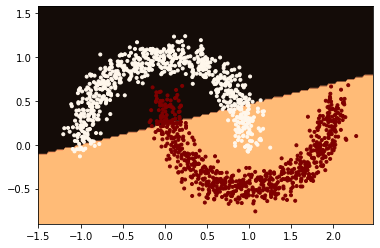

Accuracy Dataset A for rbf kernel :  0.984


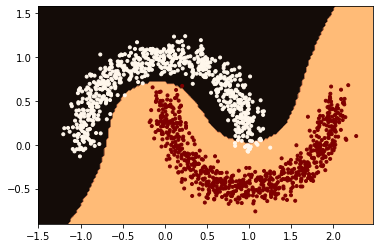

Accuracy Dataset A for poly kernel :  0.912


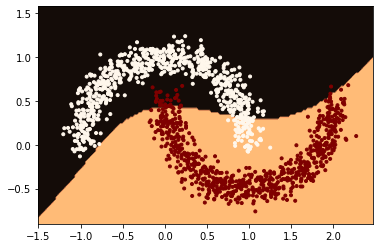

Accuracy Dataset B for linear kernel :  0.804


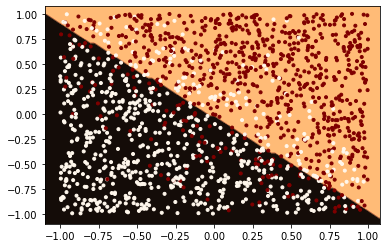

Accuracy Dataset B for rbf kernel :  0.8


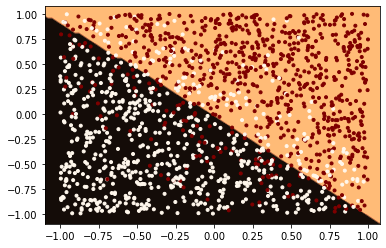

Accuracy Dataset B for poly kernel :  0.76


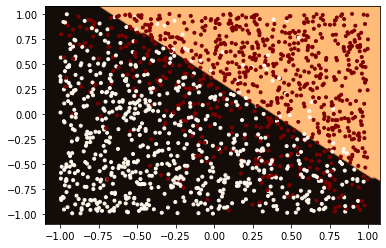

In [ ]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6
with np.load('dataset_A.npz') as data:
    X_trainA = data['arr_0']
    Y_trainA = data['arr_1']
    X_testA = data['arr_2']
    Y_testA = data['arr_3']

with np.load('dataset_B.npz') as data:
    X_trainB = data['arr_0']
    Y_trainB = data['arr_1']
    X_testB = data['arr_2']
    Y_testB = data['arr_3']

with np.load('dataset_C.npz') as data:
    X_trainC = data['arr_0']
    Y_trainC = data['arr_1']
    X_testC = data['arr_2']
    Y_testC = data['arr_3']

with np.load('dataset_D.npz') as data:
    X_trainD = data['arr_0']
    Y_trainD = data['arr_1']
    X_testD = data['arr_2']
    Y_testD = data['arr_3']
BestHyperAlin = [0.8862745098039215, 0.001, -1]
BestHyperArbf = [0.9982352156862745, 100, 10]
BestHyperApoly = [0.8686529411764705, 0.1, 6]
BestHyperBlin = [0.8313725490196079, 100.0, -1]
BestHyperBrbf = [0.8352941176470589, 0.001, 1]
BestHyperBpoly =[0.8392156862745098, 0.1, 1]
BestHyperClin = [0.7549019607843137, 0.01, -1]
BestHyperCrbf = [0.9823529411764705, 0.001, 1]
BestHyperCpoly =[0.8156862745098039, 0.001, 2]
BestHyperDlin = [0.9558823529411765, 0.01, -1]
BestHyperDrbf = [0.9779411764705882, 0.001, 1]
BestHyperDpoly =[0.9779411764705882, 0.001, 3]
num_iter_gd = 100
datasets=["A","A","A","B","B","B"]
kernels=["linear","rbf","poly","linear","rbf","poly"]
 
params=[[BestHyperAlin[1],BestHyperAlin[2]],[BestHyperArbf[1],BestHyperArbf[2]],[BestHyperApoly[1],BestHyperApoly[2]],[BestHyperBlin[1],BestHyperBlin[2]],[BestHyperBrbf[1],BestHyperBrbf[2]],[BestHyperBpoly[1],BestHyperBpoly[2]]]
lim=[[-1.5,2.5,-0.9,1.6],[-1.1,1.1,-1.1,1.1]]

count=1
for (dataset,param,kernel) in zip(datasets,params,kernels):
    if count<=3:
        lims=lim[0]
    else:
        lims=lim[1]
        
    data = np.load('dataset_'+str(dataset)+'.npz')
    X_train = data['arr_0']
    Y_train = data['arr_1']
    X_test = data['arr_2']
    Y_test = data['arr_3']

    reg_param = param[0]
    kernel_param = param[1]

    alpha = train_pred_logistic_regression(X_train, Y_train, kernel, reg_param, kernel_param, num_iter_gd)
    Y_pred = test_pred(alpha, X_train, Y_train, X_test, kernel, kernel_param)
    result = Y_pred - Y_test
    print('Accuracy Dataset '+ dataset +" for "+kernel+' kernel : ',list(result).count(0)/len(result))
    X,Y = np.meshgrid(np.arange(lims[0],lims[1],0.025),np.arange(lims[2],lims[3],0.025))
    Points = np.concatenate( (X.reshape((-1,1)), Y.reshape(-1,1)), axis=1 )
    YPredicted = test_pred(alpha, X_train, Y_train, Points, kernel, kernel_param)
    Z = np.sign(YPredicted.reshape(X.shape))
    plt.contourf(X,Y,Z,cmap='copper')
    plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='OrRd', marker='.')
    plt.show()
    count+=1


# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [ ]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here

# Function to check accuracy of predictions
def Accuracy(ytest, preds):
    count=0
    for (y1,y2) in zip(ytest,preds):
        if y1==y2:
            count+=1
    acc = count/len(ytest)
    return acc

# Function to normalise features.
def NormArr(arr):
    normalizedarr = []
    for ele in np.transpose(arr):
        maxele=ele.max()
        minele=ele.min()
        if maxele == minele:
            if maxele == 0:
                normalizedarr.append(len(ele)*[float(0)])
            else:
                normalizedarr.append(len(ele)*[float(1)])
        else:
            normalizedarr.append((ele-minele)/float(maxele-minele))
    normalizedarr=np.transpose(normalizedarr)
    return normalizedarr

# SVM classifier to give predictions
def SVMClassifier(X_train, Y_train, X_test, regparam, kerneltype, gamma=0.1, degree=3):
    if kerneltype=="linear":
        classifiermodel = svm.SVC(C=regparam, kernel=kerneltype)
        classifier = classifiermodel.fit(X_train,Y_train)
        Y_pred = classifier.predict(X_test)
        return Y_pred
    elif kerneltype=="rbf":
        classifiermodel = svm.SVC(C=regparam, kernel=kerneltype, gamma=gamma)
        classifier = classifiermodel.fit(X_train,Y_train)
        Y_pred = classifier.predict(X_test)
        return Y_pred
    elif kerneltype=="poly":
        classifiermodel = svm.SVC(C=regparam, kernel=kerneltype, gamma=gamma,degree=degree)
        classifier = classifiermodel.fit(X_train,Y_train)
        Y_pred = classifier.predict(X_test)
        return Y_pred
    else:
        return "Invalid kerneltype. Valid kernel types are \"linear\", \"poly\", \"rbf\"."


In [ ]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.

# Function for selecting hyperparameter using validaton set.
def BestHyperUsingVal(X_train, Y_train, kerneltype, TrainValSplit=0.667, RegParam=[0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0], Gamma=[0.1, 0.125, 0.25, 0.5, 1.0], Degree=[2,3,4,5,6,7]):
    TrainValDiv= int(TrainValSplit * len(X_train))
    XTrain, XVal = np.split(X_train,[TrainValDiv])
    YTrain, YVal = np.split(Y_train,[TrainValDiv])
    Best=0
    if kerneltype=="linear":
        for rp in RegParam:
                classifiermodel = svm.SVC(C=rp, kernel=kerneltype )
                classifier = classifiermodel.fit(XTrain,YTrain)
                Accuracy = classifier.score(XVal,YVal)
                AccTrain=classifier.score(XTrain,YTrain)
                if Accuracy > Best:
                    BestTrain=AccTrain
                    Best=Accuracy
                    BestArr=[Accuracy,kerneltype,rp,-1,-1,AccTrain]
                    BestClassifier = classifier
        return [BestClassifier ,BestArr]
    elif kerneltype=="poly" :
        for rp in RegParam:
            for gamma in Gamma:
                for deg in Degree:
                    classifiermodel = svm.SVC(C=rp, kernel=kerneltype, gamma=gamma,degree=deg)
                    classifier = classifiermodel.fit(XTrain,YTrain)
                    Accuracy = classifier.score(XVal,YVal)
                    AccTrain=classifier.score(XTrain,YTrain)
                    if Accuracy > Best:
                        BestTrain=AccTrain
                        Best=Accuracy
                        BestArr=[Accuracy,kerneltype,rp,gamma,deg,AccTrain]
                        BestClassifier = classifier
        return [BestClassifier , BestArr]
    elif kerneltype=="rbf":
        for rp in RegParam:
            for gamma in Gamma:
                classifiermodel = svm.SVC(C=rp, kernel = 'rbf', gamma = gamma)
                classifier = classifiermodel.fit(XTrain,YTrain)
                Accuracy = classifier.score(XVal,YVal)
                AccTrain=classifier.score(XTrain,YTrain)
                if Accuracy > Best:
                    BestTrain=AccTrain
                    Best=Accuracy
                    BestArr=[Accuracy,kerneltype,rp,gamma,-1,AccTrain]
                    BestClassifier = classifier
        return [BestClassifier , BestArr]
    else:
        return "Invalid kerneltype. Valid kernel types are \"linear\", \"poly\", \"rbf\"."


# Importing all the datasets.
with np.load('dataset_A.npz') as data:
    X_trainA = data['arr_0']
    Y_trainA = data['arr_1']
    X_testA = data['arr_2']
    Y_testA = data['arr_3']

with np.load('dataset_B.npz') as data:
    X_trainB = data['arr_0']
    Y_trainB = data['arr_1']
    X_testB = data['arr_2']
    Y_testB = data['arr_3']

with np.load('dataset_C.npz') as data:
    X_trainC = data['arr_0']
    Y_trainC = data['arr_1']
    X_testC = data['arr_2']
    Y_testC = data['arr_3']

with np.load('dataset_D.npz') as data:
    X_trainD = data['arr_0']
    Y_trainD = data['arr_1']
    X_testD = data['arr_2']
    Y_testD = data['arr_3']

X_trainC=NormArr(X_trainC)
X_testC=NormArr(X_testC)
X_trainD=NormArr(X_trainD)
X_testD=NormArr(X_testD)

# Getting best fit hyperparameters for DatasetA
classifier_rbfA , BestArr_rbfA = BestHyperUsingVal(X_trainA, Y_trainA, "rbf" )
classifier_linA , BestArr_linA = BestHyperUsingVal(X_trainA, Y_trainA, "linear" )
classifier_polyA , BestArr_polyA = BestHyperUsingVal(X_trainA, Y_trainA, "poly")
BestArrA=[BestArr_rbfA,BestArr_linA,BestArr_polyA]

# Getting best fit hyperparameters for DatasetB
classifier_rbfB , BestArr_rbfB = BestHyperUsingVal(X_trainB, Y_trainB, "rbf"  )
classifier_linB , BestArr_linB = BestHyperUsingVal(X_trainB, Y_trainB, "linear"  )
classifier_polyB , BestArr_polyB = BestHyperUsingVal(X_trainB, Y_trainB, "poly" )
BestArrB=[BestArr_rbfB,BestArr_linB,BestArr_polyB]

# Getting best fit hyperparameters for DatasetC
classifier_rbfC , BestArr_rbfC = BestHyperUsingVal(X_trainC, Y_trainC, "rbf" )
classifier_linC , BestArr_linC = BestHyperUsingVal(X_trainC, Y_trainC, "linear"  )
classifier_polyC , BestArr_polyC = BestHyperUsingVal(X_trainC, Y_trainC, "poly"  )
BestArrC=[BestArr_rbfC,BestArr_linC,BestArr_polyC]

# Getting best fit hyperparameters for DatasetD
classifier_rbfD , BestArr_rbfD = BestHyperUsingVal(X_trainD, Y_trainD, "rbf"  )
classifier_linD , BestArr_linD = BestHyperUsingVal(X_trainD, Y_trainD, "linear"  )
classifier_polyD , BestArr_polyD = BestHyperUsingVal(X_trainD, Y_trainD, "poly"  )
BestArrD=[BestArr_rbfD,BestArr_linD,BestArr_polyD]


# Printing selected hyperparameters and accuracies
datasets=["A","B","C","D"]
Data=[[X_trainA, Y_trainA, X_testA, Y_testA],[X_trainB, Y_trainB, X_testB, Y_testB],[X_trainC, Y_trainC, X_testC, Y_testC],[X_trainD, Y_trainD, X_testD, Y_testD]]
BestArr=[BestArrA,BestArrB,BestArrC,BestArrD]
kernel=["rbf","linear","poly"]

for (ele,best) in zip(datasets,BestArr):
    print("Dataset " + ele + '\n')
    for i in range(3):
        kerneltype = kernel[i]
        bestkernel=best[i]
        data=Data[i]
        Y_pred=SVMClassifier(data[0],data[1],data[2],bestkernel[2],kerneltype,bestkernel[3],bestkernel[4])
        if kerneltype=="rbf":
            print("Selected Hyperparameters for \"" +kerneltype+ "\" kernel : RegularisationParameter = " + str(bestkernel[2]) +" Gamma = " + str(bestkernel[3])  )
        elif kerneltype=="linear":
            print("Selected Hyperparameters for \"" +kerneltype+ "\" kernel : RegularisationParameter = " + str(bestkernel[2]) )
        else:
            print("Selected Hyperparameters for \"" +kerneltype+ "\" kernel : RegularisationParameter = " + str(bestkernel[2]) +" Gamma = " + str(bestkernel[3])+" Degree = " +str(bestkernel[4]) )
        print("Validation Accuracy : " + str(np.round(bestkernel[0],3)) + "  Test Accuracy : " + str(np.round(Accuracy(data[3],Y_pred),3)) ) 
        print("Training Error : " +str(np.round(1-bestkernel[5],3)) + " Test Error : " + str(np.round(1-Accuracy(data[3],Y_pred),3)))
    print("\n")   

Dataset A

Selected Hyperparameters for "rbf" kernel : RegularisationParameter = 0.5 Gamma = 1.0
Validation Accuracy : 1.0  Test Accuracy : 0.996
Training Error : 0.002 Test Error : 0.004
Selected Hyperparameters for "linear" kernel : RegularisationParameter = 1.0
Validation Accuracy : 0.884  Test Accuracy : 0.794
Training Error : 0.132 Test Error : 0.206
Selected Hyperparameters for "poly" kernel : RegularisationParameter = 0.5 Gamma = 0.5 Degree = 3
Validation Accuracy : 0.942  Test Accuracy : 0.96
Training Error : 0.064 Test Error : 0.04


Dataset B

Selected Hyperparameters for "rbf" kernel : RegularisationParameter = 2.0 Gamma = 0.25
Validation Accuracy : 0.834  Test Accuracy : 0.992
Training Error : 0.17 Test Error : 0.008
Selected Hyperparameters for "linear" kernel : RegularisationParameter = 1.0
Validation Accuracy : 0.838  Test Accuracy : 0.794
Training Error : 0.17 Test Error : 0.206
Selected Hyperparameters for "poly" kernel : RegularisationParameter = 2.0 Gamma = 1.0 Degre

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  
<h4>Here Gamma is the kernel parameter.</h4>

<h3>Dataset A</h3>
<br>
Selected Hyperparameters for "rbf" kernel : RegularisationParameter = 0.5 Gamma = 1.0<br>
Training Error : 0.002 Test Error : 0.004<br>
Selected Hyperparameters for "linear" kernel : RegularisationParameter = 1.0<br>
Training Error : 0.132 Test Error : 0.206<br>
Selected Hyperparameters for "poly" kernel : RegularisationParameter = 0.5 Gamma = 0.5 Degree = 3<br>
Training Error : 0.064 Test Error : 0.04<br>
<br>

<h3>Dataset B</h3>

Selected Hyperparameters for "rbf" kernel : RegularisationParameter = 2.0 Gamma = 0.25<br>
Training Error : 0.17 Test Error : 0.008<br>
Selected Hyperparameters for "linear" kernel : RegularisationParameter = 1.0<br>
Training Error : 0.17 Test Error : 0.206<br>
Selected Hyperparameters for "poly" kernel : RegularisationParameter = 2.0 Gamma = 1.0 Degree = 3<br>
Training Error : 0.183 Test Error : 0.04<br>


<h3>Dataset C</h3>

Selected Hyperparameters for "rbf" kernel : RegularisationParameter = 1.0 Gamma = 0.25<br>
Training Error : 0.0 Test Error : 0.018<br>
Selected Hyperparameters for "linear" kernel : RegularisationParameter = 0.25<br>
Training Error : 0.069 Test Error : 0.204<br>
Selected Hyperparameters for "poly" kernel : RegularisationParameter = 0.25 Gamma = 0.25 Degree = 3<br>
Training Error : 0.001 Test Error : 0.044<br>


<h3>Dataset D</h3>

Selected Hyperparameters for "rbf" kernel : RegularisationParameter = 0.25 Gamma = 0.1<br>
Training Error : 0.068 Test Error : 0.134<br>
Selected Hyperparameters for "linear" kernel : RegularisationParameter = 0.25<br>
Training Error : 0.026 Test Error : 0.204<br>
Selected Hyperparameters for "poly" kernel : RegularisationParameter = 0.25 Gamma = 0.5 Degree = 3<br>
Training Error : 0.038 Test Error : 0.04<br>

<h3>Observations</h3>
<br>
The SVM method and Logistic Regression have similar performance for linear kernel.<br>
<br>
Here too like Logistic Regression, the 'rbf' kernel outperforms other due to its higher flexibility than 'linear' or 'poly' kernels.<br>
<br>



dataset A


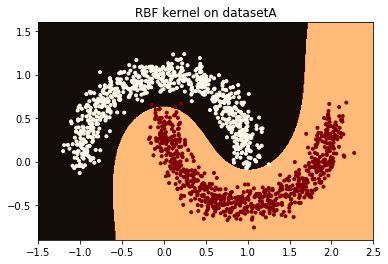

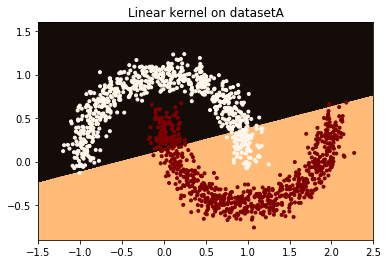

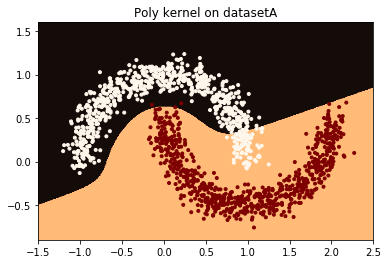

dataset B


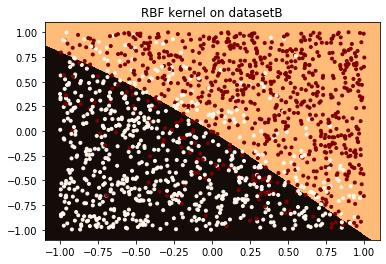

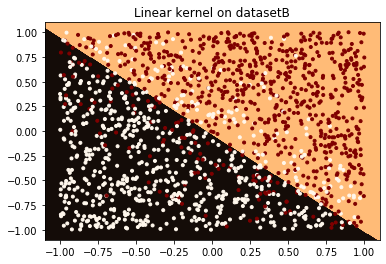

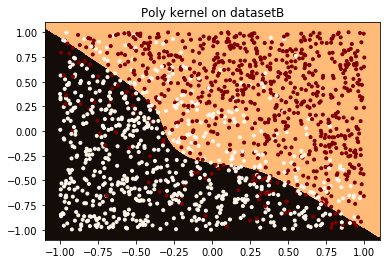

In [ ]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

print("dataset A")

# The ranges are chosen keeping the max and min in mind for both features.
X,Y=np.meshgrid(np.linspace(-1.5,2.5,400),np.linspace(-0.9,1.6,400))
Points = np.concatenate( (X.reshape((-1,1)), Y.reshape(-1,1)), axis=1 )

# rbf kernel plot 
Z1 = classifier_rbfA.decision_function(Points)
Z = np.sign(Z1.reshape(X.shape))
plt.title("RBF kernel on datasetA")
plt.contourf(X,Y,Z,cmap='copper')
plt.scatter(X_trainA[:,0], X_trainA[:,1], c=Y_trainA, cmap='OrRd', marker='.')
plt.show()

# linear kernel plot
Z1 = classifier_linA.decision_function(Points)
Z = np.sign(Z1.reshape(X.shape))
plt.title("Linear kernel on datasetA")
plt.contourf(X,Y,Z,cmap='copper')
plt.scatter(X_trainA[:,0], X_trainA[:,1], c=Y_trainA, cmap='OrRd', marker='.' )
plt.show()

# poly kernel plot
Z1 = classifier_polyA.decision_function(Points)
Z = np.sign(Z1.reshape(X.shape))
plt.title("Poly kernel on datasetA")
plt.contourf(X,Y,Z,cmap='copper')
plt.scatter(X_trainA[:,0], X_trainA[:,1], c=Y_trainA, cmap='OrRd', marker='.' )
plt.show()

print("dataset B")

# The ranges are chosen keeping the max and min in mind for both features.
X,Y=np.meshgrid(np.linspace(-1.1,1.1,400),np.linspace(-1.1,1.1,400))
Points = np.concatenate( (X.reshape((-1,1)), Y.reshape(-1,1)), axis=1 )

# rbf kernel plot 
Z1 = classifier_rbfB.decision_function(Points)
Z = np.sign(Z1.reshape(X.shape))
plt.title("RBF kernel on datasetB")
plt.contourf(X,Y,Z,cmap='copper')
plt.scatter(X_trainB[:,0], X_trainB[:,1], c=Y_trainB, cmap='OrRd', marker='.')
plt.show()

# linear kernel plot
Z1 = classifier_linB.decision_function(Points)
Z = np.sign(Z1.reshape(X.shape))
plt.title("Linear kernel on datasetB")
plt.contourf(X,Y,Z,cmap='copper')
plt.scatter(X_trainB[:,0], X_trainB[:,1], c=Y_trainB, cmap='OrRd', marker='.' )
plt.show()

# poly kernel plot
Z1 = classifier_polyB.decision_function(Points)
Z = np.sign(Z1.reshape(X.shape))
plt.title("Poly kernel on datasetB")
plt.contourf(X,Y,Z,cmap='copper')
plt.scatter(X_trainB[:,0], X_trainB[:,1], c=Y_trainB, cmap='OrRd', marker='.' )
plt.show()


# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [ ]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)
def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    def single_tree(X,Y, num_nodes_stop):
        
        def Hp_calc(left, right, count_this):
            p_left = np.array(np.count_nonzero(left==count_this,axis=0)/len(left)) 
            p_right = np.array(np.count_nonzero(right==count_this,axis=0)/len(right))
            total_left = len(left)
            total_right = len(right)
            p_left[p_left<=0]=1e-14
            p_right[p_right<=0]=1e-14
            p_left[p_left>=1]=1-1e-14
            p_right[p_right>=1]=1-1e-14
            frac_left = total_left/(total_left + total_right)
            frac_right = total_right/(total_left + total_right)
            Hp_left = -p_left * np.log2(p_left) - (1-p_left) * np.log2(1-p_left)
            Hp_right = -p_right * np.log2(p_right) - (1-p_right) * np.log2(1-p_right)
            Hp_split = frac_left * Hp_left + frac_right * Hp_right
            Hp_split=-Hp_split
            return Hp_split
        
        if(len(Y) >= num_nodes_stop):
            if(list(Y).count(Y[0]) != len(Y)):
                y =np.tile(np.array([Y]).transpose(), (1, len(X[0])))
                data = np.array(X).transpose()
                y=y.transpose()
                data_args = np.argsort(data)
                y =y[np.arange(np.shape(data)[0])[:,np.newaxis], data_args].transpose()
                data =data[np.arange(np.shape(data)[0])[:,np.newaxis], data_args].transpose()
                total_counts = len(y)+1-num_nodes_stop
                row_addn = 1-num_nodes_stop   
                if(total_counts <= num_nodes_stop):
                    total_counts = len(y)
                    row_addn=0
                accuracy_matrix =[]
                if(criterion == 'accuracy'):
                    for i in range(num_nodes_stop,total_counts):
                        up = y[:i,:]
                        down = y[i:,:]
                        mones_up = np.array(np.count_nonzero(up==-1,axis=0)/total_counts)
                        ones_down = np.array(np.count_nonzero(down==1,axis=0)/total_counts)
                        accuracy_mp = mones_up + ones_down
                        accuracy_matrix.append(accuracy_mp)
                        ones_up = np.array(np.count_nonzero(up==1,axis=0)/total_counts)
                        mones_down = np.array(np.count_nonzero(down==-1,axis=0)/total_counts)
                        accuracy_pm = ones_up + mones_down
                        accuracy_matrix.append(accuracy_pm)
                elif(criterion =='entropy') :
                    for i in range(num_nodes_stop,total_counts):
                        left = y[:i,:]
                        right = y[i:,:]
                        Hp_p = Hp_calc(left, right, 1)
                        Hp_m = Hp_calc(left, right, -1)
                        accuracy_matrix.append(Hp_p)
                        accuracy_matrix.append(Hp_m)
                accuracy_matrix = np.around(np.array(accuracy_matrix),3)
                max_accuracy = np.amax(accuracy_matrix) #accuracy obtained for the split
                maximum_indices = np.array(np.where(np.array(accuracy_matrix)==max_accuracy))
                row_index =np.array(maximum_indices[0]/2,dtype=int)
                column_index = maximum_indices[1]
                ind = (np.abs( row_index-(len(Y)/2)  )).argmin() #finding index in middle
                row = row_index[ind] - row_addn                  #+ num_nodes_stop-1
                column = column_index[ind]
                node_type = row%2
                split_value = (data[row,column] + data[row+1,column] )/2
                indice = X[:,column].argsort()
                X = X[indice]
                Y=np.array(Y)
                Y=Y[indice]
                return (node_type,split_value,column ), (X[:row+1,:],Y[:row+1]) , (X[row+1:,:],Y[row+1:])
            else:
                X_left = X
                Y_left = np.array(Y)
                X_right = np.array([])
                Y_right = np.array([])
                split_value =None
                column = None
                if(Y[0]==1):
                    node_type = 1       
                else:
                    node_type = 0
                return (node_type,split_value,column ), (X_left,Y_left) , (X_right,Y_right)
        else:
            X_left = X
            Y_left = np.array(Y)
            X_right = np.array([])
            Y_right = np.array([])
            split_value =None
            column = None
            if( (list(Y).count(1)/len(Y)) >=0.5):
                node_type = 1
            else:
                node_type = 0
            return (node_type,split_value,column ), (X_left,Y_left) , (X_right,Y_right)
    
    def full_tree(X,Y,num_nodes_stop, node_val, index , position,parameters, tree_list):   #returns list of the (node_type,split_val,column )  parent_node_no, curr_node_no, 
        if(position == 'left'):
            p=-1
        elif(position == 'right'):
            p=1
        else:
            p=0
        if(len(Y) == 0 ):
            return parameters ,index, tree_list
        elif(list(Y).count(Y[0]) ==len(Y)):
            parameters.append({'name':index[1] ,'val':Y[0], 'column':None, 'threshold':None, 'type':'leaf','parent':index[0] ,'position':position})   #,'parent':parent})
            tree_list.append([index[1], Y[0], None, None, 0, index[0],p] )
            return parameters ,index, tree_list
        elif(len(Y)<=num_nodes_stop):
            parameters.append({'name':index[1] ,'val':node_val, 'column':None, 'threshold':None,'type':'leaf','parent':index[0], 'position':position})   #,'parent':parent}) #i have to modify node type to get node val ie if left ot right
            tree_list.append([index[1], node_val, None, None, 0, index[0],p] )
            return parameters ,index, tree_list
        else:
            (node_type, split_value, column),(X_l,Y_l),(X_r,Y_r) = single_tree(X,Y,num_nodes_stop)  # marking --one
            parameters.append({'name':index[1] ,'val':None, 'column':column, 'threshold':split_value , 'type':'node','parent':index[0],'position':position}) #position will come from previous split also parent
            tree_list.append([index[1], None, column, split_value, 1, index[0], p] )
            if(node_type==0):
                node_val_left = -1
                node_val_right = 1
            else:
                node_val_left = 1
                node_val_right =-1
            parent_node_no = index[1]
            index[1] = index[1] +1
            return_val_left, index, tree_list = full_tree(X_l, Y_l, num_nodes_stop, node_val_left, [parent_node_no ,index[1]],'left' ,parameters, tree_list) # one is parent, this has positiin left
            index[1] = index[1] + 1
            return_val_right, index, tree_list = full_tree(X_r, Y_r, num_nodes_stop, node_val_right, [parent_node_no,index[1]], 'right',parameters, tree_list) # one is parent, this has positiin right
            return parameters, index, tree_list
            
    parameters = []
    index = []
    tree_list=[]
    parameters,index, tree_list = full_tree(X,Y,num_nodes_stop,None,[0,1],'root',parameters,tree_list)
        
    return tree_list
    

def eval_decision_tree(tree, test_X):
    def sortby(data, column):
        data=np.array(data)
        indice = data[:,column].argsort()
        return data[indice],indice
    def split_node(data,data_index,threshold,column):
        data, indice = sortby(data,column)
        data_index = data_index[indice]
        index = np.where(np.array(data[:,column]) >= threshold)
        if(len(index[0]) ==0):
            datal =data
            datar =np.array([])
            data_indexl = data_index
            data_indexr = np.array([])
        else :
            index = index[0][0]
            datal= data[:index,:]
            datar = data[index:,:]
            data_indexl = data_index[:index]
            data_indexr = data_index[index:]
        return datal, datar, data_indexl, data_indexr
    
    def next_node(sorted_tree, current_node, position):  
        sorted_tree=np.array(sorted_tree)
        index = np.where( (np.array(sorted_tree[:,5])  ==current_node) & (np.array(sorted_tree[:,6])==position) )[0][0]
        node = sorted_tree[index]
        return node

    def predict(tree, data, Y, data_index, data_index_array,  current_node ): # imp tree should be sorted by name    #the point is at the current node. If it is leaf return predicted value or move to next node
        if(len(data)==0):
            return Y, data_index_array
        elif(current_node[4]==0) :  # if current node is leaf
            Y = Y + ([current_node[1]]*len(data))
            data_index_array =list(data_index_array) + list(data_index)
            return Y, data_index_array
        else:
            split1, split2, data_indexl, data_indexr = split_node(data, data_index, current_node[3],current_node[2])
            split1_node = next_node(tree, current_node[0], -1) 
            split2_node = next_node(tree, current_node[0], 1) 
            Y, data_index_array = predict(tree, split1, Y, data_indexl, data_index_array, split1_node)
            Y, data_index_array = predict(tree, split2, Y, data_indexr, data_index_array, split2_node)
            return Y, data_index_array
    
    sorted_tree = sortby(tree,0)[0]
    predicted = []
    data_index_array = []
    data_index = np.array([i for i in range(len(test_X))])
    predicted_array, data_index_array = predict(sorted_tree,test_X, predicted,data_index, data_index_array, sorted_tree[0])
    predicted_array = np.array(predicted_array)
    indices = np.array(data_index_array).argsort()
    predicted_array = predicted_array[indices]
    return predicted_array

In [ ]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.

percentage = 0.667
crits=['accuracy','entropy']
stopping_points = [1,2,5,8,12,15,20,25,35,50]
datasets =['A','B','C','D']
accuracy = []
nodes = []
for dset in datasets :
    print('---------------------------------')
    print('Dataset '+str(dset))
    print('---------------------------------')
    data = np.load('dataset_'+str(dset)+'.npz')
    X_train = data['arr_0']
    Y_train = data['arr_1']
    X_test = data['arr_2']
    Y_test = data['arr_3']
    index = int(percentage * len(X_train))
    X=X_train[:index]
    Y=Y_train[:index]
    X_val=X_train[index:]
    Y_val=Y_train[index:]
    for i in stopping_points:
        for crit in crits:
            tree = train_decision_tree(X,Y,i,criterion=crit)
            Y_pred1 = eval_decision_tree(tree,X_val)
            result1 = Y_pred1 - Y_val
            Y_pred2=eval_decision_tree(tree,X)
            result2 = Y_pred2 - Y
            Y_pred3=eval_decision_tree(tree,X_test)
            result3 = Y_pred3 - Y_test
            print('criterion : '+crit+' | num_nodes_stop : '+str(i)+' Validation Accuracy : ' +str(round(list(result1).count(0)/len(result1),3))+" Training Error: "+str(round(1 - list(result2).count(0)/len(result2),3))+" Test Error: "+str(round(1 - list(result3).count(0)/len(result3),3)))
        print("\n")

---------------------------------
Dataset A
---------------------------------
criterion : accuracy | num_nodes_stop : 1 Validation Accuracy : 0.982 Training Error: 0.0 Test Error: 0.026
criterion : entropy | num_nodes_stop : 1 Validation Accuracy : 1.0 Training Error: 0.0 Test Error: 0.006


criterion : accuracy | num_nodes_stop : 2 Validation Accuracy : 0.98 Training Error: 0.005 Test Error: 0.032
criterion : entropy | num_nodes_stop : 2 Validation Accuracy : 1.0 Training Error: 0.0 Test Error: 0.006


criterion : accuracy | num_nodes_stop : 5 Validation Accuracy : 0.926 Training Error: 0.066 Test Error: 0.098
criterion : entropy | num_nodes_stop : 5 Validation Accuracy : 1.0 Training Error: 0.0 Test Error: 0.006


criterion : accuracy | num_nodes_stop : 8 Validation Accuracy : 0.85 Training Error: 0.186 Test Error: 0.18
criterion : entropy | num_nodes_stop : 8 Validation Accuracy : 1.0 Training Error: 0.0 Test Error: 0.006


criterion : accuracy | num_nodes_stop : 12 Validation Accur

criterion : accuracy | num_nodes_stop : 20 Validation Accuracy : 0.888 Training Error: 0.214 Test Error: 0.243
criterion : entropy | num_nodes_stop : 20 Validation Accuracy : 0.925 Training Error: 0.139 Test Error: 0.254


criterion : accuracy | num_nodes_stop : 25 Validation Accuracy : 0.866 Training Error: 0.158 Test Error: 0.343
criterion : entropy | num_nodes_stop : 25 Validation Accuracy : 0.896 Training Error: 0.244 Test Error: 0.284


criterion : accuracy | num_nodes_stop : 35 Validation Accuracy : 0.933 Training Error: 0.079 Test Error: 0.107
criterion : entropy | num_nodes_stop : 35 Validation Accuracy : 0.955 Training Error: 0.143 Test Error: 0.071


criterion : accuracy | num_nodes_stop : 50 Validation Accuracy : 0.47 Training Error: 0.485 Test Error: 0.598
criterion : entropy | num_nodes_stop : 50 Validation Accuracy : 0.903 Training Error: 0.188 Test Error: 0.089




TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

<h3>Dataset A</h3>

Based on <b>Entropy</b>, best size of node to stop splitting is <b>1</b>.<br>
Training Error: 0.0<br>
Test Error: 0.006<br>

Based on <b>Accuracy</b>, best size of node to stop splitting is <b>1</b>.<br>
Training Error: 0.0<br>
Test Error: 0.026<br>

<h3>Dataset B</h3>

Based on <b>Entropy</b>, best size of node to stop splitting is <b>1</b>.<br>
Training Error: 0.0<br>
Test Error: 0.26<br>

Based on <b>Accuracy</b>, best size of node to stop splitting is <b>2</b>.<br>
Training Error: 0.065 <br>
Test Error: 0.258<br>

<h3>Dataset C</h3>

Based on <b>Entropy</b>, best size of node to stop splitting is <b>1</b>.<br>
Training Error: 0.033 <br>
Test Error: 0.128<br>

Based on <b>Accuracy</b>, best size of node to stop splitting is<b> 12</b>.<br>
Training Error: 0.133<br>
Test Error: 0.209<br>

<h3>Dataset D</h3>

Based on <b>Entropy</b>, best size of node to stop splitting is <b>5</b>.<br>
Training Error: 0.026<br>
Test Error: 0.101<br>

Based on <b>Accuracy</b>, best size of node to stop splitting is <b>2</b>.<br>
Training Error: 0.023 <br>
Test Error: 0.118<br>

<h3>Observations</h3>
<br> 1. The decision tree divides the space into axis-parallel hyperplanes. <br>
<br> 2. Its decision boundaries are linear.  <br>
 <br> 3. The entropy split gives better decision boundaries than accuracy most of the times. This is because, in accuracy if some training points of a particular class are more than other classes, the decision will be biased in favour of that class. But in case of entropy, probability of a class in present in the split is also taken into account.  <br>



---------------------------------
Dataset A
---------------------------------
Accuracy :  0.97


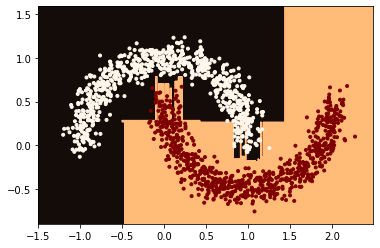

---------------------------------
Dataset B
---------------------------------
Accuracy :  0.752


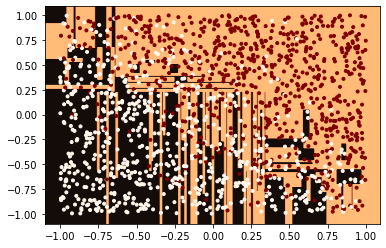

In [ ]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

datasets=['A','B']
crit = 'accuracy'
lim=[[-1.5,2.5,-0.9,1.6],[-1.1,1.1,-1.1,1.1]]

for dataset in datasets:
    print('---------------------------------')
    print('Dataset '+str(dataset))
    print('---------------------------------')
    if dataset == 'A':
        lims=lim[0]
        numnodestop=1
    else:
        lims=lim[1]
        numnodestop=2
    data = np.load('dataset_'+str(dataset)+'.npz')
    X_train = data['arr_0']
    Y_train = data['arr_1']
    X_test  = data['arr_2']
    Y_test  = data['arr_3']
    tree = train_decision_tree(X_train,Y_train,numnodestop,crit)
    Y_pred = eval_decision_tree(tree,X_test)
    result = Y_pred - Y_test
    print('Accuracy : ',list(result).count(0)/len(result))
    X,Y = np.meshgrid(np.arange(lims[0],lims[1],0.01),np.arange(lims[2],lims[3],0.01))
    Points = np.concatenate( (X.reshape((-1,1)), Y.reshape(-1,1)), axis=1 )
    YPredicted = eval_decision_tree(tree,Points)
    Z = np.sign(YPredicted.reshape(X.shape))
    plt.contourf(X,Y,Z,cmap='copper')
    plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='OrRd', marker='.')
    plt.show()

# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [ ]:
# CodeWrite cell
# Write Random Forest classifier. 
def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, criterion='accuracy', a=0.5, b=0.5):
    
    def feature_selector(target_tile,b):
        total_features = len(target_tile[0])
        features_to_mask =total_features -  int(b*total_features)
        indexes  =np.arange(total_features)
        np.random.shuffle(indexes)
        masked_features = indexes[:features_to_mask]
        copy_data = target_tile
        copy_data[:,masked_features]=0
        return copy_data


    def single_tree(X,Y, num_nodes_stop):
        
        def Hp_calc(left, right, count_this):
            p_left = np.array(np.count_nonzero(left==count_this,axis=0)/len(left)) 
            p_right = np.array(np.count_nonzero(right==count_this,axis=0)/len(right))
            total_left = len(left)
            total_right = len(right)
            p_left[p_left<=0]=1e-14
            p_right[p_right<=0]=1e-14
            p_left[p_left>=1]=1-1e-14
            p_right[p_right>=1]=1-1e-14
            frac_left = total_left/(total_left + total_right)
            frac_right = total_right/(total_left + total_right)
            Hp_left = -p_left * np.log2(p_left) - (1-p_left) * np.log2(1-p_left)
            Hp_right = -p_right * np.log2(p_right) - (1-p_right) * np.log2(1-p_right)
            Hp_split = frac_left * Hp_left + frac_right * Hp_right
            Hp_split=-Hp_split
            return Hp_split
        
        if(len(Y) >= num_nodes_stop):
            if(list(Y).count(Y[0]) != len(Y)):
                y =np.tile(np.array([Y]).transpose(), (1, len(X[0])))
                y=feature_selector(y,b)  
                data = np.array(X).transpose()
                y=y.transpose()
                data_args = np.argsort(data)
                y =y[np.arange(np.shape(data)[0])[:,np.newaxis], data_args].transpose()
                data =data[np.arange(np.shape(data)[0])[:,np.newaxis], data_args].transpose()
                total_counts = len(y)+1-num_nodes_stop
                row_addn = 1-num_nodes_stop   
                if(total_counts <= num_nodes_stop):
                    total_counts = len(y)
                    row_addn=0
                accuracy_matrix =[]
                if(criterion == 'accuracy'):
                    for i in range(num_nodes_stop,total_counts):
                        up = y[:i,:]
                        down = y[i:,:]
                        mones_up = np.array(np.count_nonzero(up==-1,axis=0)/total_counts)
                        ones_down = np.array(np.count_nonzero(down==1,axis=0)/total_counts)
                        accuracy_mp = mones_up + ones_down
                        accuracy_matrix.append(accuracy_mp)
                        ones_up = np.array(np.count_nonzero(up==1,axis=0)/total_counts)
                        mones_down = np.array(np.count_nonzero(down==-1,axis=0)/total_counts)
                        accuracy_pm = ones_up + mones_down
                        accuracy_matrix.append(accuracy_pm)
                elif(criterion =='entropy') :
                    for i in range(num_nodes_stop,total_counts):
                        left = y[:i,:]
                        right = y[i:,:]
                        Hp_p = Hp_calc(left, right, 1)
                        Hp_m = Hp_calc(left, right, -1)
                        accuracy_matrix.append(Hp_p)
                        accuracy_matrix.append(Hp_m)
                accuracy_matrix = np.around(np.array(accuracy_matrix),3)
                max_accuracy = np.amax(accuracy_matrix) #accuracy obtained for the split
                maximum_indices = np.array(np.where(np.array(accuracy_matrix)==max_accuracy))
                row_index =np.array(maximum_indices[0]/2,dtype=int)
                column_index = maximum_indices[1]
                ind = (np.abs( row_index-(len(Y)/2)  )).argmin() #finding index in middle
                row = row_index[ind] - row_addn                  #+ num_nodes_stop-1
                column = column_index[ind]
                node_type = row%2
                split_value = (data[row,column] + data[row+1,column] )/2
                indice = X[:,column].argsort()
                X = X[indice]
                Y=np.array(Y)
                Y=Y[indice]
                return (node_type,split_value,column ), (X[:row+1,:],Y[:row+1]) , (X[row+1:,:],Y[row+1:])
            else:
                X_left = X
                Y_left = np.array(Y)
                X_right = np.array([])
                Y_right = np.array([])
                split_value =None
                column = None
                if(Y[0]==1):
                    node_type = 1       
                else:
                    node_type = 0
                return (node_type,split_value,column ), (X_left,Y_left) , (X_right,Y_right)
        else:
            X_left = X
            Y_left = np.array(Y)
            X_right = np.array([])
            Y_right = np.array([])
            split_value =None
            column = None
            if( (list(Y).count(1)/len(Y)) >=0.5):
                node_type = 1
            else:
                node_type = 0
            return (node_type,split_value,column ), (X_left,Y_left) , (X_right,Y_right)

    # list = [parent_node_no, curr_node_no]  # leaf=0, node=1, root=2 # position : left -1, right 1 , root 0
    def full_tree(X,Y,num_nodes_stop, node_val, index , position,parameters, tree_list):   #returns list of the (node_type,split_val,column )  parent_node_no, curr_node_no, 
        if(position == 'left'):
            p=-1
        elif(position == 'right'):
            p=1
        else:
            p=0
        if(len(Y) == 0 ):
            return parameters ,index, tree_list
        elif(list(Y).count(Y[0]) ==len(Y)):
            parameters.append({'name':index[1] ,'val':Y[0], 'column':None, 'threshold':None, 'type':'leaf','parent':index[0] ,'position':position})   #,'parent':parent})
            tree_list.append([index[1], Y[0], None, None, 0, index[0],p] )
            return parameters ,index, tree_list
        elif(len(Y)<=num_nodes_stop):
            parameters.append({'name':index[1] ,'val':node_val, 'column':None, 'threshold':None,'type':'leaf','parent':index[0], 'position':position})   #,'parent':parent}) #i have to modify node type to get node val ie if left ot right
            tree_list.append([index[1], node_val, None, None, 0, index[0],p] )
            return parameters ,index, tree_list
        else:
            (node_type, split_value, column),(X_l,Y_l),(X_r,Y_r) = single_tree(X,Y,num_nodes_stop)  # marking --one
            parameters.append({'name':index[1] ,'val':None, 'column':column, 'threshold':split_value , 'type':'node','parent':index[0],'position':position}) #position will come from previous split also parent
            tree_list.append([index[1], None, column, split_value, 1, index[0], p] )
            if(node_type==0):
                node_val_left = -1
                node_val_right = 1
            else:
                node_val_left = 1
                node_val_right =-1
            parent_node_no = index[1]
            index[1] = index[1] +1
            return_val_left, index, tree_list = full_tree(X_l, Y_l, num_nodes_stop, node_val_left, [parent_node_no ,index[1]],'left' ,parameters, tree_list) # one is parent, this has positiin left
            index[1] = index[1] + 1
            return_val_right, index, tree_list = full_tree(X_r, Y_r, num_nodes_stop, node_val_right, [parent_node_no,index[1]], 'right',parameters, tree_list) # one is parent, this has positiin right
            return parameters, index, tree_list

    def data_generator(data,y,a):
        split = int(a*len(data))
        joint_data = np.append(data,np.array(y).reshape(len(y),1),axis=1)
        np.random.shuffle(joint_data)
        return joint_data[:split,:-1], joint_data[:split,-1:].reshape(1,split)[0]
    
    forest = []
    for i in range(num_trees):
        parameters = []
        index = []
        tree_list=[]
        random = data_generator(X,Y,a)
        X_random = random[0]
        Y_random = random[1]
        parameters,index, tree_list = full_tree(X_random, Y_random ,num_nodes_stop,None,[0,1],'root',parameters,tree_list)
        forest.append(tree_list)
    
        
    return forest
    

def eval_decision_tree(random_forest, test_X):
    def sortby(data, column):
        data=np.array(data)
        indice = data[:,column].argsort()
        return data[indice],indice
    def split_node(data,data_index,threshold,column):
        data, indice = sortby(data,column)
        data_index = data_index[indice]
        index = np.where(np.array(data[:,column]) >= threshold)
        if(len(index[0]) ==0):
            datal =data
            datar =np.array([])
            data_indexl = data_index
            data_indexr = np.array([])
        else :
            index = index[0][0]
            datal= data[:index,:]
            datar = data[index:,:]
            data_indexl = data_index[:index]
            data_indexr = data_index[index:]
        return datal, datar, data_indexl, data_indexr
    
    def next_node(sorted_tree, current_node, position):   # tree should be sorted according to index, position - whether we want left node or right
        sorted_tree=np.array(sorted_tree)
        index = np.where( (np.array(sorted_tree[:,5])  ==current_node) & (np.array(sorted_tree[:,6])==position) )[0][0]
        node = sorted_tree[index]
        return node
        
    #tree should be sorted
    def predict(tree, data, Y, data_index, data_index_array,  current_node ): # imp tree should be sorted by name    #the point is at the current node. If it is leaf return predicted value or move to next node
        if(len(data)==0):
            return Y, data_index_array
        elif(current_node[4]==0) :  # if current node is leaf
            Y = Y + ([current_node[1]]*len(data))
            data_index_array =list(data_index_array) + list(data_index)
            return Y, data_index_array
        else:
            split1, split2, data_indexl, data_indexr = split_node(data, data_index, current_node[3],current_node[2])
            split1_node = next_node(tree, current_node[0], -1) 
            split2_node = next_node(tree, current_node[0], 1) 
            Y, data_index_array = predict(tree, split1, Y, data_indexl, data_index_array, split1_node)
            Y, data_index_array = predict(tree, split2, Y, data_indexr, data_index_array, split2_node)
            return Y, data_index_array
    
    all_predictions =[]
    for tree in random_forest:
        sorted_tree = sortby(tree,0)[0]
        predicted = []
        data_index_array = []
        data_index = np.array([i for i in range(len(test_X))])
        predicted_array, data_index_array = predict(sorted_tree,test_X, predicted,data_index, data_index_array, sorted_tree[0])
        predicted_array = np.array(predicted_array)
        indices = np.array(data_index_array).argsort()
        predicted_array = predicted_array[indices]
        all_predictions.append(predicted_array)
    predictions_comp = np.sign(np.sum(np.array(all_predictions),axis=0))
    predictions_comp[np.where(predictions_comp==0)]=-1
    
    return predictions_comp


In [ ]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.

percentage = 0.667
crit1 = 'accuracy'
crit2 = 'entropy'
crits =[crit1,crit2]
numnodestops=[1,5,10,20,50]
a=0.5
b=0.5
num_tree =np.array([10,20,30,40])
datasets =['A','B','C','D']
accuracy = []
nodes = []
print("parameter a = 0.5 and parameter b = 0.5")
for crit in crits:
    print('---------------------------------')
    print('Criteria : '+str(crit.upper()))
    print('---------------------------------')
    for dset in datasets :
        print('---------------------------------')
        print('Dataset '+str(dset))
        print('---------------------------------')
        data = np.load('dataset_'+str(dset)+'.npz')
        X_train = data['arr_0']
        Y_train = data['arr_1']
        X_test  = data['arr_2']
        Y_test  = data['arr_3']
        index = int(percentage * len(X_train))
        X=X_train[:index] 
        Y=Y_train[:index]
        X_val=X_train[index:]
        Y_val=Y_train[index:]
        for treecount in num_tree:
            for numnodestop in numnodestops:
                forest = train_random_forest(X, Y, treecount, numnodestop, crit, a, b)
                Y_pred = eval_decision_tree(forest, X_val)
                result = Y_pred - Y_val
                Y_pred2 = eval_decision_tree(forest, X)
                result2 = Y_pred2 - Y
                Y_pred3 = eval_decision_tree(forest, X_test)
                result3 = Y_pred3 - Y_test
                print('num_nodes_stop : '+str(numnodestop)+' | num_trees : '+str(treecount)+' | Validation Accuracy : '+str(list(result).count(0)/len(result)) + " | Training Error: " +str(round(1-list(result2).count(0)/len(result2),3))+" | Testing Error: " + str(round(1-list(result3).count(0)/len(result3),3)))

parameter a = 0.5 and parameter b = 0.5
---------------------------------
Criteria : ACCURACY
---------------------------------
---------------------------------
Dataset A
---------------------------------
num_nodes_stop : 1 | num_trees : 10 | Validation Accuracy : 0.956 | Training Error: 0.003 | Testing Error: 0.056
num_nodes_stop : 5 | num_trees : 10 | Validation Accuracy : 0.954 | Training Error: 0.031 | Testing Error: 0.062
num_nodes_stop : 10 | num_trees : 10 | Validation Accuracy : 0.926 | Training Error: 0.076 | Testing Error: 0.092
num_nodes_stop : 20 | num_trees : 10 | Validation Accuracy : 0.87 | Training Error: 0.107 | Testing Error: 0.116
num_nodes_stop : 50 | num_trees : 10 | Validation Accuracy : 0.934 | Training Error: 0.075 | Testing Error: 0.092
num_nodes_stop : 1 | num_trees : 20 | Validation Accuracy : 0.972 | Training Error: 0.002 | Testing Error: 0.028
num_nodes_stop : 5 | num_trees : 20 | Validation Accuracy : 0.964 | Training Error: 0.031 | Testing Error: 0.056
n

num_nodes_stop : 20 | num_trees : 20 | Validation Accuracy : 0.9701492537313433 | Training Error: 0.124 | Testing Error: 0.03
num_nodes_stop : 50 | num_trees : 20 | Validation Accuracy : 0.9402985074626866 | Training Error: 0.135 | Testing Error: 0.053
num_nodes_stop : 1 | num_trees : 30 | Validation Accuracy : 0.9626865671641791 | Training Error: 0.0 | Testing Error: 0.089
num_nodes_stop : 5 | num_trees : 30 | Validation Accuracy : 0.9552238805970149 | Training Error: 0.049 | Testing Error: 0.101
num_nodes_stop : 10 | num_trees : 30 | Validation Accuracy : 0.9776119402985075 | Training Error: 0.064 | Testing Error: 0.024
num_nodes_stop : 20 | num_trees : 30 | Validation Accuracy : 0.9776119402985075 | Training Error: 0.124 | Testing Error: 0.03
num_nodes_stop : 50 | num_trees : 30 | Validation Accuracy : 0.9402985074626866 | Training Error: 0.207 | Testing Error: 0.047
num_nodes_stop : 1 | num_trees : 40 | Validation Accuracy : 0.9552238805970149 | Training Error: 0.004 | Testing Erro

num_nodes_stop : 10 | num_trees : 40 | Validation Accuracy : 0.5 | Training Error: 0.504 | Testing Error: 0.512
num_nodes_stop : 20 | num_trees : 40 | Validation Accuracy : 0.5 | Training Error: 0.496 | Testing Error: 0.488
num_nodes_stop : 50 | num_trees : 40 | Validation Accuracy : 0.5 | Training Error: 0.496 | Testing Error: 0.488
---------------------------------
Dataset D
---------------------------------
num_nodes_stop : 1 | num_trees : 10 | Validation Accuracy : 0.8805970149253731 | Training Error: 0.034 | Testing Error: 0.207
num_nodes_stop : 5 | num_trees : 10 | Validation Accuracy : 0.8955223880597015 | Training Error: 0.117 | Testing Error: 0.178
num_nodes_stop : 10 | num_trees : 10 | Validation Accuracy : 0.4925373134328358 | Training Error: 0.293 | Testing Error: 0.509
num_nodes_stop : 20 | num_trees : 10 | Validation Accuracy : 0.9552238805970149 | Training Error: 0.192 | Testing Error: 0.077
num_nodes_stop : 50 | num_trees : 10 | Validation Accuracy : 0.5447761194029851 

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

<h3>Criteria : Accuracy</h3>

<h3>Dataset A</h3>

Best values for size of node to stop splitting : 1<br>
Best value for number of trees : 30<br>
Training Error : 0.0<br>
Testing Error : 0.028<br>

<h3>Dataset B</h3>

Best values for size of node to stop splitting : 1<br>
Best value for number of trees : 30<br>
Training Error : 0.027<br>
Testing Error : 0.214<br>

<h3>Dataset C</h3>

Best values for size of node to stop splitting : 5<br>
Best value for number of trees : 30<br>
Training Error : 0.047<br>
Testing Error : 0.138<br>

<h3>Dataset D</h3>

Best values for size of node to stop splitting : 10<br>
Best value for number of trees : 30<br>
Training Error : 0.064<br>
Testing Error : 0.024<br>

<h3>Criteria : Entropy</h3>

<h3>Dataset A</h3>

Best values for size of node to stop splitting : 1<br>
Best value for number of trees : 30<br>
Training Error : 0.0<br>
Testing Error : 0.002<br>

<h3>Dataset B</h3>

Best values for size of node to stop splitting : 5<br>
Best value for number of trees : 20<br>
Training Error : 0.169<br>
Testing Error : 0.208<br>

<h3>Dataset C</h3>

Best values for size of node to stop splitting : 1<br>
Best value for number of trees : 10<br>
Training Error : 0.349<br>
Testing Error : 0.31<br>

<h3>Dataset D</h3>

Best values for size of node to stop splitting : 20<br>
Best value for number of trees : 30<br>
Training Error : 0.195 <br>
Testing Error : 0.071<br>

<h3>Observations</h3>
<br>
The performance increases as we use random forest rather than a single tree.<br>
<br> Each tree uses less data and features hence avoids overfitting the noise. If many such trees are considered mostly the general pattern in the data will be captured and overfitting will be avoided <br>
<br>
The random forest performs best for number of trees around 30 for the given datasets.<br>
<br>
We can increase minimum number of nodes at each leaf to introduce regularization to avoid overfitting. The number at which highest accuracy occurs depends on the dataset as 1 node to stop splitting might lead to overfitting in some cases.<br>
<br>
At the same time increasing number of nodes to stop splitting too much might lead to underfitting.We usually have to find a balance.<br>
<br>







Accuracy A :  0.972


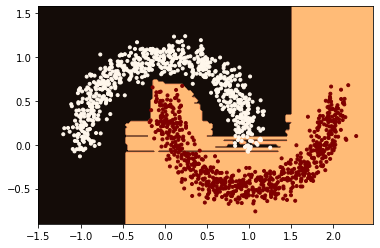

Accuracy A :  0.788


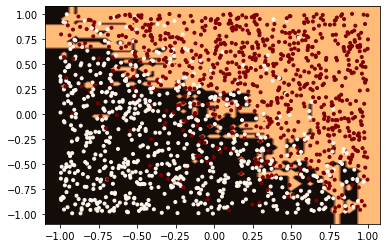

In [ ]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

lim=[[-1.5,2.5,-0.9,1.6],[-1.1,1.1,-1.1,1.1]]
aset=[0.5,0.5]
bset=[0.5,0.5]
numtreeset=[30,30]
numnodestopset=[1,1]
datasets=['A','B']
crit = 'accuracy'

for (dataset,a,b,numtree,numnodestop) in zip(datasets,aset,bset,numtreeset,numnodestopset):
    if dataset == 'A':
        lims=lim[0]
    else:
        lims=lim[1]
    data = np.load('dataset_'+str(dataset)+'.npz')
    X_train = data['arr_0']
    Y_train = data['arr_1']
    X_test  = data['arr_2']
    Y_test  = data['arr_3']
    forest = train_random_forest(X_train,Y_train,numtree,numnodestop,crit,a,b)
    Y_pred = eval_decision_tree(forest, X_test)
    result = Y_pred - Y_test
    print('Accuracy A : ',list(result).count(0)/len(result))
    X,Y = np.meshgrid(np.arange(lims[0],lims[1],0.025),np.arange(lims[2],lims[3],0.025))
    Points = np.concatenate( (X.reshape((-1,1)), Y.reshape(-1,1)), axis=1 )
    YPredicted = eval_decision_tree(forest,Points)
    Z = np.sign(YPredicted.reshape(X.shape))
    plt.contourf(X,Y,Z,cmap='copper')
    plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='OrRd', marker='.')
    plt.show()